In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from google.colab import files
import io

In [2]:
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

Saving customer_reviews.csv to customer_reviews.csv


In [4]:
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     20 non-null     object
 1   sentiment  20 non-null     object
dtypes: object(2)
memory usage: 452.0+ bytes


None

,review,sentiment
0,"The product is amazing, I love it!",positive
1,"Does not work as advertised, a scam.",negative
2,"Terrible service, very dissatisfied.",negative
3,Excellent quality and fast delivery.,positive
4,"Top-notch product, works perfectly.",positive


In [5]:
df = df[['review', 'sentiment']]
df.dropna(inplace=True)

In [6]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [7]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

In [8]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [9]:
df['cleaned_review'] = df['review'].apply(preprocess_text)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_review'], df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment'])

In [11]:
vectorizer = TfidfVectorizer(max_features=20000, stop_words='english', ngram_range=(1,3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [12]:
smote = SMOTE(random_state=42)
X_train_tfidf, y_train = smote.fit_resample(X_train_tfidf, y_train)

In [13]:
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_tfidf, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [14]:
y_pred = model.predict(X_test_tfidf)

In [15]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.7500
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



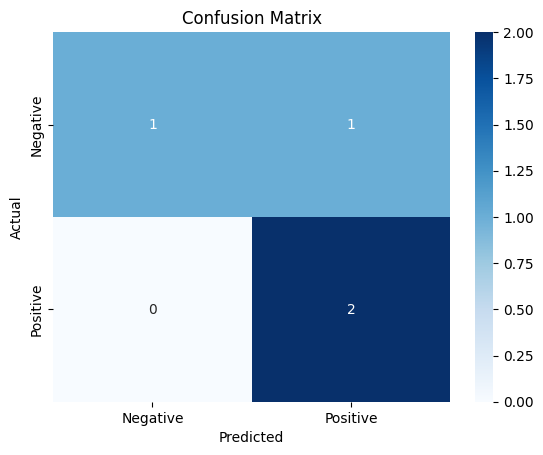

In [16]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()